In [52]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.misc import derivative
import time

In [53]:
data= pd.read_csv("Misra1b_Data.txt",names=['y','x'], sep=" ")

data

,y,x
NaN,10.07,77.6
NaN,14.73,114.9
NaN,17.94,141.1
NaN,23.93,190.8
NaN,29.61,239.9
NaN,35.18,289.0
NaN,40.02,332.8
NaN,44.82,378.4
NaN,50.76,434.8
NaN,55.05,477.3


In [54]:
y = torch.from_numpy(data['y'].to_numpy(np.float64))
x = torch.from_numpy(data['x'].to_numpy(np.float64))

b = torch.tensor([500,0.0001],requires_grad=True)
# b = torch.tensor([0.15,0.008,0.01],requires_grad=True)

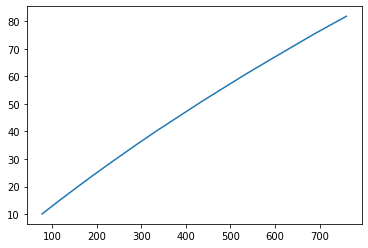

In [55]:
plt.plot(x.numpy(),y.numpy())

In [56]:
## Numerical Differentiation

b = np.array([500,0.0001]).reshape(-1,1)
# b = np.array([0.7,4]).reshape(-1,1)

x=x.detach().numpy()

u=0.1 #beta multiply identity matrix
beta = 10
V_prev = 0



def f0(b0):
    return  b0*(1-np.power((1+b[1]*x/2),-2))-y.detach().numpy()  
def f1(b1):
    return  b[0]*(1-np.power((1+b1*x/2),-2))-y.detach().numpy()   

start_time = time.perf_counter()   
    
for c in range(290):

    y_pred = b[0]*(1-np.power((1+b[1]*x/2),-2))
    error = (y_pred - y.detach().numpy()).reshape(-1,1)
    
    d_b0 = derivative(f0,b[0] , dx=1e-6)
    d_b1 = derivative(f1,b[1] , dx=1e-6)
    
     
    jacobian = np.transpose(np.array([d_b0,d_b1]))
    dParam = np.matmul(np.matmul(np.linalg.inv((np.matmul(np.transpose(jacobian),jacobian)+u*np.identity(len(b)))),np.transpose(jacobian)),error)
    b -= dParam
    V = np.sum(np.square(error))
    if(V > V_prev):
            u *= beta
    else:
            u /= beta
    V_prev = V
    print("c: ",c," error: ",V," B:", b)
    
    if V <  7.5464681553E-02:
        break
print("time taken to execute: ",time.perf_counter()-start_time)  
print("SD error is", np.std(np.square(error)))

c:  0  error:  10994.317207569991  B: [[4.99914730e+02]
 [2.41760656e-04]]
c:  1  error:  41.28473659566044  B: [[4.99886951e+02]
 [2.50591968e-04]]
c:  2  error:  7.311471078570726  B: [[4.99590735e+02]
 [2.50794785e-04]]
c:  3  error:  7.293250055004091  B: [[4.96659908e+02]
 [2.52421354e-04]]
c:  4  error:  7.119409846322078  B: [[4.70298133e+02]
 [2.67251781e-04]]
c:  5  error:  5.8884440364170665  B: [[3.56127705e+02]
 [3.40344529e-04]]
c:  6  error:  138.05327918135347  B: [[3.33033445e+02]
 [3.92403663e-04]]
c:  7  error:  3.605029034514967  B: [[3.37316976e+02]
 [3.91292472e-04]]
c:  8  error:  0.07578962585208712  B: [[3.37983684e+02]
 [3.90407397e-04]]
c:  9  error:  0.07546545452464613  B: [[3.37997404e+02]
 [3.90390990e-04]]
c:  10  error:  0.07546468153555895  B: [[3.37997459e+02]
 [3.90390916e-04]]
time taken to execute:  0.010779000000070482
SD error is 0.0030664039840575226


In [57]:
def Jacobian(loss,params,numParams):
    
    jacobian = torch.empty(len(loss), numParams) 
    
    for i in range(len(loss)):
        
        loss[i].backward(retain_graph=True)
        
        for n in range(numParams):
            jacobian[i][n] = params.grad[n]
        params.grad.zero_()      
    return jacobian    

In [58]:
## Automatic Differentiation
num_param = len(b)
u=0.1 #beta multiply identity matrix
beta = 10
error_prev = 0
start_time = time.perf_counter()
for c in range(200):

    y_pred = b[0]*(1-torch.pow((1+b[1]*x/2),-2))

    loss = y_pred-y
    error = torch.sum(torch.square(loss)) #residual sum of squares
    print("",c," error is: ",error.detach().numpy()," b is ", b.detach().numpy())
    jacobian = Jacobian(loss,b,len(b))

    dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian)+u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),loss.float())
    with torch.no_grad():
        b -=dParam
    
        if(error > error_prev):
            u *= beta
        else:
            u /= beta
        error_prev = error
    if error<  7.5464681553E-02:#7.88539786689E+02:  given residual sum of squares
        break
print("time taken to execute: ",time.perf_counter()-start_time) 
print("SD error is", np.std(np.square(loss.detach().numpy())))

TypeError: pow() received an invalid combination of arguments - got (numpy.ndarray, int), but expected one of:
 * (Tensor input, Tensor exponent, *, Tensor out)
 * (Number self, Tensor exponent, *, Tensor out)
 * (Tensor input, Number exponent, *, Tensor out)


In [ ]:
plt.plot(y_pred.detach(),'g', y,'r')